# Purpose:
- Develop new z-drift method
- Previous method is not reliable, and too complicated
- Changes:
    - Consider only within session drift. 
        - Cross-session drift is going to be calculated from z-stack matching
    - Pre-register z-stack using motion correction results
        - In this way, larger FOVs with more matched regions are used (more reliable)
        - CAUTION: the order of z-stack will change from the end to the beginning of the session. 
            - Force specifying the order of z-stack acquisition
        - Use the mean of 1 min registration resultst, close to the z-stack acquisition
        - This should be done on the raw z-stacks.
        - Consider this later.
# Pre-requisite:
- Dev on 1 min EMF and registered z-stack (downloaded from codeocean)
- Needs suite2p to apply motion correction to z-stack
- Use napari for visualization

# Issues:
- Too low correlation coefficient values from the recent dataset
    - From GCaMP characterization data
    - Is this due to data itself, or inconsistency in the protocol?
    - Check with previous data first (omFISH GAD2 data, from multiplane_zdrift_comparison notebooks)

In [2]:
from suite2p.registration.register import shift_frames, nonrigid, rigid
import napari

from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import h5py
import os

import skimage
from pystackreg import StackReg
import scipy
import cv2

from dask import delayed, compute
from dask.distributed import Client, LocalCluster

# Previous results

In [105]:
zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
plane_interval = 0.75
lamf_table_fn = zdrift_dir / 'multiplane_zdrift_lamf.pkl'
lamf_table = pd.read_pickle(lamf_table_fn)

lamf_table['min_cc_episodes'] = lamf_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
lamf_table['min_cc_fl'] = lamf_table.apply(lambda x: np.min(x.cc_fl), axis=1)
lamf_table['zdrift_episodes'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
lamf_table['zdrift_fl'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)


In [99]:
lamf_table

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,ophys_experiment_id,equipment_name,full_genotype,...,targeted_structure,date_of_acquisition,session_type,config,water,ocid,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl
0,1275171148,371,VISp,"[31, 33, 34, 35, 36, 39]","[0.8768556166206293, 0.8622728681245287, 0.865...","[29, 42]","[0.854972648510691, 0.7993668147424484]",1.275171e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2023-06-06 16:22:44.443,TRAINING_1_gratings,2x4,0.210,1276358257,0.851542,0.799367,6.00,9.75
1,1275171143,163,VISp,"[27, 31, 33, 34, 36, 37]","[0.8805471356973789, 0.8376754216254007, 0.850...","[24, 41]","[0.8704477670409961, 0.8763228700369714]",1.275171e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2023-06-06 16:22:44.443,TRAINING_1_gratings,2x4,0.210,1276358250,0.880402,0.870448,7.50,12.75
2,1275171152,71,VISam,"[29, 31, 33, 35, 36, 41]","[0.8103952532916524, 0.8149027512391827, 0.822...","[24, 42]","[0.8140243999576189, 0.9004550552556044]",1.275171e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISam,2023-06-06 16:22:44.443,TRAINING_1_gratings,2x4,0.210,1276358260,0.810395,0.814024,9.00,13.50
3,1275171145,265,VISp,"[30, 31, 32, 45, 45, 45]","[0.8570002794762288, 0.856290283539191, 0.8401...","[27, 44]","[0.8473424176751275, 0.8408194646728513]",1.275171e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2023-06-06 16:22:44.443,TRAINING_1_gratings,2x4,0.210,1276358254,0.854178,0.840819,11.25,12.75
4,1275171146,71,VISp,"[26, 28, 32, 33, 34, 35]","[0.8814019772733436, 0.8341259026862089, 0.836...","[26, 35]","[0.840161572346171, 0.8264307772975529]",1.275171e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2023-06-06 16:22:44.443,TRAINING_1_gratings,2x4,0.210,1276358247,0.845717,0.826431,6.75,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1259825182,180,VISp,"[34, 36, 37, 38, 39, 39, 40, 39]","[0.8823398756321197, 0.8096668900575845, 0.820...","[33, 39]","[0.8979176688859544, 0.9127384769076885]",1.259825e+09,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2023-04-03 16:27:41.544,OPHYS_6_images_B,2x4,0.025,1253938723,0.882340,0.897918,3.75,4.50
1028,1259825187,379,VISp,"[36, 35, 35, 36, 39, 39, 40, 39]","[0.866526420773805, 0.868996324033165, 0.88327...","[35, 39]","[0.8378972397034957, 0.9006521870080532]",1.259825e+09,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2023-04-03 16:27:41.544,OPHYS_6_images_B,2x4,0.025,1253938729,0.866526,0.837897,2.25,3.00
1029,1259825184,294,VISp,"[35, 34, 34, 36, 38, 38, 39, 38]","[0.9155071750810286, 0.9113533712590953, 0.915...","[34, 38]","[0.9146955284058458, 0.9129324109197129]",1.259825e+09,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2023-04-03 16:27:41.544,OPHYS_6_images_B,2x4,0.025,1253938726,0.915507,0.912932,2.25,3.00
1030,1259825194,354,VISam,"[33, 33, 33, 34, 37, 38, 38, 39]","[0.9291147141312438, 0.9323762119575356, 0.940...","[33, 39]","[0.9231894488004021, 0.922492521445899]",1.259825e+09,MESO.1,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISam,2023-04-03 16:27:41.544,OPHYS_6_images_B,2x4,0.025,1253938744,0.922227,0.922493,4.50,4.50


In [106]:
lamf_table.columns

Index(['oeid', 'depth', 'region', 'mpi_episodes', 'cc_episodes', 'mpi_fl',
       'cc_fl', 'ophys_experiment_id', 'equipment_name', 'full_genotype',
       'cre_line', 'indicator', 'ophys_session_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'config', 'water', 'ocid', 'range_y', 'range_x',
       'min_cc_episodes', 'min_cc_fl', 'zdrift_episodes', 'zdrift_fl'],
      dtype='object')

In [102]:
i = 0
row = lamf_table.iloc[i]
oeid = row['oeid']
ocid = row['ocid']
exp_dir = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}'
zstack_fn = exp_dir / f'{oeid}_zstack_reg.h5'
with h5py.File(zstack_fn, 'r') as f:
    zstack = f['data'][()]
emf_fn = exp_dir / f'{oeid}_segment_fov.h5'
with h5py.File(emf_fn, 'r') as f:
    emf = f['data'][()]


In [135]:
zdrift_fn = exp_dir / f'{oeid}_zdrift_ref_{oeid}.h5'
zdrift_results = {}
with h5py.File(zdrift_fn, 'r') as f:
    zdrift_results['corrcoef_pre'] = f['corrcoef_pre'][()]
    zdrift_results['use_clahe'] = f['ops']['use_clahe'][()]
    zdrift_results['use_valid_pix_pc'] = f['ops']['use_valid_pix_pc'][()]
    zdrift_results['use_valid_pix_sr'] = f['ops']['use_valid_pix_sr'][()]


In [161]:
row.cc_episodes

[0.8768556166206293,
 0.8622728681245287,
 0.8653826938705732,
 0.8595431085027895,
 0.8516472426829269,
 0.8515423668734091]

In [136]:
zdrift_results

{'corrcoef_pre': array([0.58249097, 0.59236075, 0.60308353, 0.61931898, 0.6332451 ,
        0.64621951, 0.65913051, 0.67082422, 0.6777726 , 0.68362203,
        0.6893405 , 0.69365778, 0.69907824, 0.70471706, 0.7103705 ,
        0.71600355, 0.72557891, 0.73029885, 0.73396878, 0.73770287,
        0.74044269, 0.74304343, 0.7519656 , 0.75897462, 0.76480668,
        0.77275293, 0.78141007, 0.78995125, 0.79697196, 0.80504515,
        0.81189188, 0.81883922, 0.82518504, 0.8306071 , 0.83639962,
        0.84029799, 0.84668709, 0.84890782, 0.85096593, 0.85159004,
        0.84922993, 0.8478847 , 0.84160668, 0.83871179, 0.83221188,
        0.82560869, 0.81397259, 0.80112938, 0.78997624, 0.77821241,
        0.76392443, 0.75037347, 0.73844221, 0.72835575, 0.71775454,
        0.70807535, 0.69858185, 0.68898613, 0.68268648, 0.67619614,
        0.67312199, 0.66770509, 0.66567383, 0.66027732, 0.6579632 ,
        0.65255653, 0.64963266, 0.64684962, 0.64319836, 0.63606138,
        0.6325987 , 0.62777951, 

In [104]:
viewer = napari.Viewer()
viewer.add_image(zstack, name='zstack')
viewer.add_image(emf, name='emf')

<Image layer 'emf' at 0x1d595abe730>

In [108]:
# calculate z-drift using the new z-drift protocol (lamf-analysis/zdrift_refactor)
range_y = row.range_y
range_x = row.range_x

emf_crop = emf[:,range_y[0]:range_y[1], range_x[0]:range_x[1]]
zstack_crop = zstack[:,range_y[0]:range_y[1], range_x[0]:range_x[1]]


In [3]:

def two_step_register_to_stack(fov, stack, use_clahe=True, use_valid_pix_pc=False, use_valid_pix_sr=True,
                               sr_method='rigid_body'):
    """Register FOV to z-stack using 2-step registration
    First register using phase correlation and then using StackReg

    Parameters
    ----------
    fov : np.ndarray (2d)
        FOV image
    zstack : np.ndarray (3d)
        z-stack images
    use_clahe : bool, optional
        If to adjust contrast using CLAHE for registration, by default True
    use_valid_pix_pc : bool, optional
        If to use valid pixels (non-blank pixels after transfromation)
        to calculate correlation coefficient during the 1st step registration, by default True
    use_valid_pix_sr : bool, optional
        If to use valid pixels (non-blank pixels after transfromation)
        to calculate correlation coefficient during the 2nd step registration, by default True
    sr_method : str, optional
        StackReg method, by default 'affine'

    Returns
    -------
    np.ndarray (1d: int)
        matched plane index
    np.ndarray (2d: float)
        correlation coefficient for each plane in the z-stack
    np.ndarray (2d: float)
        registered FOV
    np.ndarray (2d: float)
        transformation matrix for StackReg RIGID_BODY
    np.ndarray (1d: int or float)
        translation shift
    """
    assert len(fov.shape) == 2
    assert len(stack.shape) == 3
    assert fov.shape == stack.shape[1:]

    stack_pre = med_filt_z_stack(stack)
    stack_pre = rolling_average_stack(stack_pre)

    fov_reg_pc, corrcoef_pc_arr, shift_list = fov_stack_register_phase_correlation(
        fov, stack_pre, use_clahe=use_clahe, use_valid_pix=use_valid_pix_pc)
    best_match_pc_ind = np.argmax(corrcoef_pc_arr)
    fov_for_stackreg = fov_reg_pc[best_match_pc_ind]
    best_shift = shift_list[best_match_pc_ind]
    corrcoef_sr_arr, fov_reg, best_tmat, tmat_list = fov_stack_register_stackreg(
        fov_for_stackreg, stack_pre, use_clahe=use_clahe, sr_method=sr_method, use_valid_pix=use_valid_pix_sr)
    matched_plane_index = np.argmax(corrcoef_sr_arr)
    return matched_plane_index, corrcoef_sr_arr, corrcoef_pc_arr, fov_reg, fov_for_stackreg, best_tmat, best_shift


def fov_stack_register_stackreg(fov, stack, use_clahe=True, sr_method='rigid_body', tmat=None, use_valid_pix=True):

    if use_clahe:
        fov_for_reg = image_normalization(skimage.exposure.equalize_adapthist(
            fov.astype(np.uint16)))  # normalization to make it uint16
        stack_for_reg = np.zeros_like(stack)
        for pi in range(stack.shape[0]):
            stack_for_reg[pi, :, :] = image_normalization(
                skimage.exposure.equalize_adapthist(stack[pi, :, :].astype(np.uint16)))
    else:
        fov_for_reg = fov.copy()
        stack_for_reg = stack.copy()
    
    if sr_method == 'affine':
        sr = StackReg(StackReg.AFFINE)
    elif sr_method == 'rigid_body':
        sr = StackReg(StackReg.RIGID_BODY)
    else:
        raise ValueError('"sr_method" should be either "affine" or "rigid_body"')
    
    assert fov.min() >= 0
    if use_valid_pix:
        # valid_pix_threshold = fov.min()/10 # to remove blank pixels after transformation
        valid_pix_threshold = 10 # to remove blank pixels after transformation
    else:
        valid_pix_threshold = -1 # to include all pixels
    num_pix_threshold = fov.shape[0] * fov.shape[1] / 2
    
    corrcoef_arr = np.zeros(stack.shape[0])
    
    if tmat is None:
        temp_cc = []
        tmat_list = []
        for zi in range(stack_for_reg.shape[0]):
            zstack_plane_clahe = stack_for_reg[zi]
            zstack_plane = stack[zi]
            tmat = sr.register(zstack_plane_clahe, fov_for_reg)
            fov_reg = sr.transform(fov, tmat=tmat)            
            valid_y, valid_x = np.where(fov_reg > valid_pix_threshold)
            if len(valid_y) > num_pix_threshold:
                temp_cc.append(np.corrcoef(zstack_plane[valid_y, valid_x].flatten(),
                                           fov_reg[valid_y, valid_x].flatten())[0,1])
                tmat_list.append(tmat)
            else:
                temp_cc.append(0)
                tmat_list.append(np.eye(3))
        temp_ind = np.argmax(temp_cc)
        best_tmat = tmat_list[temp_ind]
    else:
        best_tmat = tmat
    fov_reg = sr.transform(fov, tmat=best_tmat)
    valid_y, valid_x = np.where(fov_reg > valid_pix_threshold)
    for zi, zstack_plane in enumerate(stack):
        corrcoef_arr[zi] = np.corrcoef(zstack_plane[valid_y, valid_x].flatten(),
                                   fov_reg[valid_y, valid_x].flatten())[0,1]
    return corrcoef_arr, fov_reg, best_tmat, tmat_list    


def fov_stack_register_phase_correlation(fov, stack, use_clahe=True, use_valid_pix=True):
    """ Reigster FOV to each plane in the stack

    Parameters
    ----------
    fov : np.ndarray (2d)
        FOV image
    stack : np.ndarray (3d)
        stack images
    use_clahe: bool, optional
        If to adjust contrast using CLAHE for registration, by default True
    use_valid_pix : bool, optional
        If to use valid pixels (non-blank pixels after transfromation)
        to calculate correlation coefficient, by default True

    Returns
    -------
    np.ndarray (3d)
        stack of FOV registered to each plane in the input stack
    np.array (1d)
        correlation coefficient between the registered fov and the stack in each plane
    list
        list of translation shifts
    """
    assert len(fov.shape) == 2
    assert len(stack.shape) == 3
    assert fov.shape == stack.shape[1:]

    if use_clahe:
        fov_for_reg = image_normalization(skimage.exposure.equalize_adapthist(
            fov.astype(np.uint16)))  # normalization to make it uint16
        stack_for_reg = np.zeros_like(stack)
        for pi in range(stack.shape[0]):
            stack_for_reg[pi, :, :] = image_normalization(
                skimage.exposure.equalize_adapthist(stack[pi, :, :].astype(np.uint16)))
    else:
        fov_for_reg = fov.copy()
        stack_for_reg = stack.copy()

    fov_reg_stack = np.zeros_like(stack_for_reg)
    corrcoef_arr = np.zeros(stack_for_reg.shape[0])
    shift_list = []
    for pi in range(stack_for_reg.shape[0]):
        shift, _, _ = skimage.registration.phase_cross_correlation(
            stack_for_reg[pi, :, :], fov_for_reg, normalization=None)
        fov_reg = scipy.ndimage.shift(fov, shift)
        fov_reg_stack[pi, :, :] = fov_reg
        if use_valid_pix:
            valid_y, valid_x = np.where(fov_reg > 0)
            corrcoef_arr[pi] = np.corrcoef(stack[pi, valid_y, valid_x].flatten(
            ), fov_reg[valid_y, valid_x].flatten())[0, 1]
        else:
            corrcoef_arr[pi] = np.corrcoef(
                stack[pi, :, :].flatten(), fov_reg.flatten())[0, 1]
        shift_list.append(shift)    
    return fov_reg_stack, corrcoef_arr, shift_list


def med_filt_z_stack(zstack, kernel_size=5):
    """Get z-stack with each plane median-filtered

    Parameters
    ----------
    zstack : np.ndarray
        z-stack to apply median filtering
    kernel_size : int, optional
        kernel size for median filtering, by default 5
        It seems only certain odd numbers work, e.g., 3, 5, 11, ...

    Returns
    -------
    np.ndarray
        median-filtered z-stack
    """
    filtered_z_stack = []
    for image in zstack:
        filtered_z_stack.append(cv2.medianBlur(
            image.astype(np.uint16), kernel_size))
    return np.array(filtered_z_stack)


def rolling_average_stack(stack, rolling_window_flank=2):
    """ Get a stack with each plane rolling-averaged
    
    Parameters
    ----------
    stack : np.ndarray
        stack to apply rolling average
    rolling_window_flank : int, optional
        flank size for rolling average, by default 2
        
    Returns
    -------
    np.ndarray
        rolling-averaged stack
    """
    new_stack = np.zeros(stack.shape)
    for i in range(stack.shape[0]):
        new_stack[i] = np.mean(stack[max(0, i-rolling_window_flank) : min(stack.shape[0], i+rolling_window_flank), :, :],
                                axis=0)
    return new_stack


def image_normalization(image, im_thresh=0, dtype=np.uint16):
    """Normalize 2D image and convert to specified dtype
    Prevent saturation.

    Args:
        image (np.ndarray): input image (2D)
                            Just works with 3D data as well.
        im_thresh (float, optional): threshold when calculating pixel intensity percentile.
                            0 by default
        dtype (np.dtype, optional): output data type. np.uint16 by default
    Return:
        norm_image (np.ndarray)
    """
    clip_image = np.clip(image, np.percentile(
        image[image > im_thresh], 0.2), np.percentile(image[image > im_thresh], 99.8))
    norm_image = (clip_image - np.amin(clip_image)) / \
        (np.amax(clip_image) - np.amin(clip_image)) * 0.9
    image_dtype = ((norm_image + 0.05) *
                    np.iinfo(np.uint16).max * 0.9).astype(dtype)
    return image_dtype

In [123]:
zstack.shape

(81, 512, 512)

In [163]:
matched_plane_index, corrcoef_sr_arr, corrcoef_pc_arr, fov_reg, fov_for_stackreg, best_tmat, best_shift = \
    two_step_register_to_stack(emf_crop[0], zstack_crop, use_clahe=True, use_valid_pix_pc=True, use_valid_pix_sr=True)

In [156]:
viewer = napari.Viewer()
viewer.add_image(zstack_crop, name='zstack_crop')
viewer.add_image(fov_reg, name='fov_reg')
viewer.add_image(fov_for_stackreg, name='fov_for_stackreg')

<Image layer 'fov_for_stackreg' at 0x1d5b041b4c0>

In [157]:
matched_plane_index

33

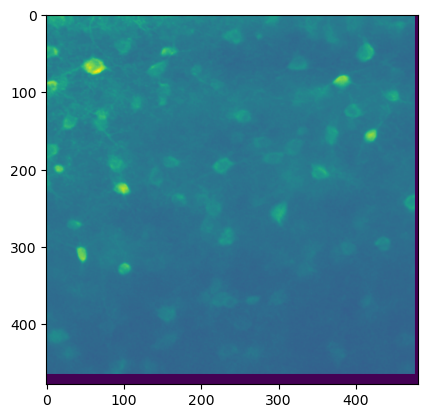

In [148]:

plt.imshow(fov_for_stackreg)

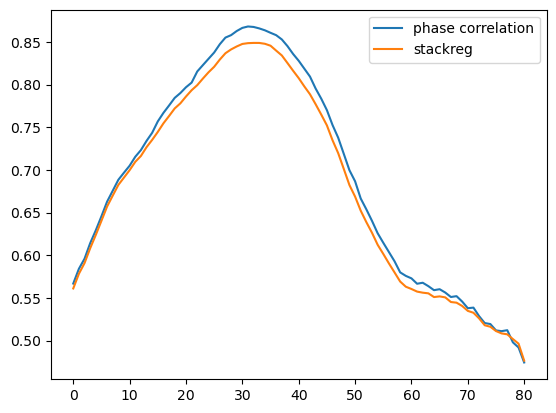

In [164]:
fig, ax = plt.subplots()
ax.plot(corrcoef_pc_arr, label='phase correlation')
ax.plot(corrcoef_sr_arr, label='stackreg')
ax.legend()

## Step 2 seems lower than phase correlation
- valid pixel set to 10. When 0, the results are even lower.
- Compare all the results in the previous batch (lamf; valid pixel = 10)

In [166]:
sr_cc = []
pc_cc = []
for i, row in lamf_table.iterrows():
    oeid = row['oeid']
    ocid = row['ocid']
    exp_dir = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}'
    zdrift_fn = exp_dir / f'{oeid}_zdrift_ref_{oeid}.h5'
    if not zdrift_fn.exists():
        exp_dir = zdrift_dir / 'container_none' / f'experiment_{oeid}'
        zdrift_fn = exp_dir / f'{oeid}_zdrift_ref_{oeid}.h5'
        if not zdrift_fn.exists():
            print(f'zdrift file not found: {zdrift_fn}')
            continue
    with h5py.File(zdrift_fn, 'r') as f:
        pc_cc.append(np.max(f['corrcoef_pre'][()]))
        sr_cc.append(row.cc_episodes[-1])
        

zdrift file not found: \\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_none\experiment_1331941045\1331941045_zdrift_ref_1331941045.h5
zdrift file not found: \\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_none\experiment_1331941054\1331941054_zdrift_ref_1331941054.h5


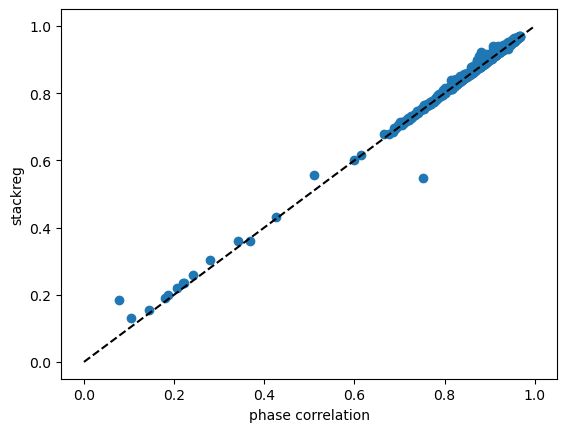

In [167]:
fig, ax = plt.subplots()
ax.scatter(pc_cc, sr_cc)
ax.set_xlabel('phase correlation')
ax.set_ylabel('stackreg')
ax.plot([0, 1], [0, 1], color='k', linestyle='--')

## StackReg does not add much
- This is the case with valid pix = 10, which is arbitrarily high.
- This is with rigid body, which in theory should not add much to the results.
- Affine was very unstable.
# Conclusion
- Just use phase correlation.
    - Identify the source of error and fix it
- The only problem is with FOV tilt, and even in that case we don't know how much it is detremental.
- Additionally, FOV tilt should be dealt with imaging system.


## Checking erros with the previous dataset

In [169]:
np.where(lamf_table.min_cc_episodes.values < 0.5)

(array([ 15,  18,  19,  21,  36,  57, 456, 457, 458, 459, 460, 461, 462,
        463, 608], dtype=int64),)

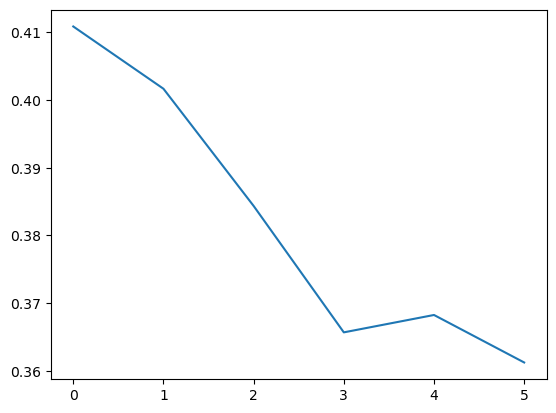

In [188]:
i = 18
row = lamf_table.iloc[i]
oeid = row['oeid']
ocid = row['ocid']
exp_dir = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}'
zstack_fn = exp_dir / f'{oeid}_zstack_reg.h5'
with h5py.File(zstack_fn, 'r') as f:
    zstack = f['data'][()]
emf_fn = exp_dir / f'{oeid}_segment_fov.h5'
with h5py.File(emf_fn, 'r') as f:
    emf = f['data'][()]
viewer = napari.Viewer()
viewer.add_image(zstack, name='zstack')
i = 0
for fov in emf:
    viewer.add_image(fov, name=f'fov_{i}', visible=False)
    i += 1
plt.plot(row.cc_episodes)

In [189]:
viewer = napari.Viewer()
viewer.add_image(emf, name='emf')

<Image layer 'emf' at 0x1d672542640>

### Notes
- 15: z-stack registration error
- 18, 19, 21: unknown reason. slight error in z-stack reg but looks fine for registration with the FOV. Maybe too sparse pattern?
- 36, 57: error in the FOV.
- 456-463: weird error in the later FOVs (last 3 out of 8 images are CLAHE'd already?).
- 603: z-stack error (very low SNR)

# Check registration using phase correlation only
- on the 1 min EMF data from recent GCaMP pilots

In [190]:
data_dir = Path(r'D:\zdrift_test\zdrift')
opids = [id for id in os.listdir(data_dir) if id.isnumeric() and (data_dir/id).is_dir()]


In [201]:
opid = opids[0]
opid_dir = data_dir/opid

emf_movie = np.load(opid_dir/'emf_movie.npy')
zstack = np.load(opid_dir/'ref_zstack.npy')
xy_range = np.load(opid_dir/'xy_range.npy', allow_pickle=True).item()


In [205]:
range_y = [int(xy_range['range_y'][0]), -int(xy_range['range_y'][1])]
range_x = [int(xy_range['range_x'][0]), -int(xy_range['range_x'][1])]

emf_crop = emf_movie[:, range_y[0]:range_y[1], range_x[0]:range_x[1]]
zstack_crop = zstack[:, range_y[0]:range_y[1], range_x[0]:range_x[1]]
stack_pre = med_filt_z_stack(zstack_crop)
stack_pre = rolling_average_stack(stack_pre)

In [211]:
use_clahe = True
use_valid_pix = True
matched_plane_indices = np.zeros(emf_crop.shape[0], dtype=int)
corrcoef = []
segment_reg_imgs = []
shift_list = []
for i in range(emf_crop.shape[0]):
# for i in range(3):
    fov_reg, cc, shift = fov_stack_register_phase_correlation(
        emf_crop[i], stack_pre, use_clahe=use_clahe, use_valid_pix=use_valid_pix)
    matched_plane_indices[i] = np.argmax(cc)
    corrcoef.append(cc)
    segment_reg_imgs.append(fov_reg)
    shift_list.append(shift)
corrcoef = np.asarray(corrcoef)

results = {'matched_plane_indices': matched_plane_indices,
                'corrcoef': corrcoef,
                'segment_fov_registered': segment_reg_imgs,
                'zstack_crop': zstack_crop,
                'shift': shift_list,
                'use_clahe': use_clahe,
                'use_valid_pix': use_valid_pix}

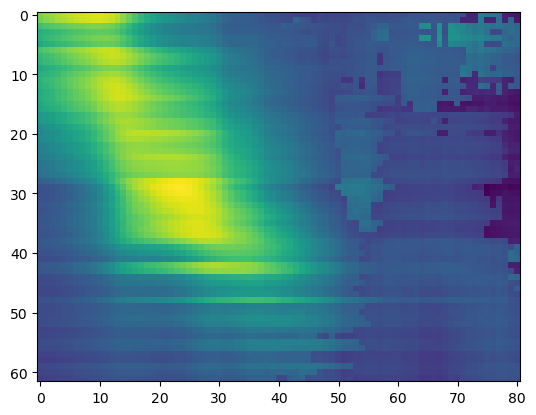

In [212]:
plt.imshow(corrcoef)

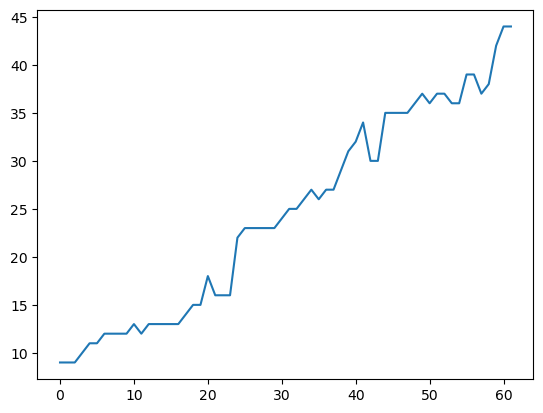

In [213]:
plt.plot(matched_plane_indices)

In [62]:
def wrapper_calculate_zdrift(opid, use_clahe=True, use_valid_pix=True, 
                             data_dir=Path(r'D:\zdrift_test\zdrift')):
    opid_dir = data_dir/opid
    # save_fn = opid_dir/f'{opid}_zdrift_pconly_dc.npy'
    save_fn = opid_dir/f'{opid}_zdrift_pconly_nondc.npy'
    if not save_fn.exists():
        try:
            # emf_movie = np.load(opid_dir/'emf_movie.npy')
            # zstack = np.load(opid_dir/'ref_zstack_dc.npy')
            emf_movie = np.load(opid_dir/'emf_movie_nondc.npy')
            zstack = np.load(opid_dir/'ref_zstack.npy')

            xy_range = np.load(opid_dir/'xy_range.npy', allow_pickle=True).item()
            range_y = [int(xy_range['range_y'][0]), -int(xy_range['range_y'][1])]
            range_x = [int(xy_range['range_x'][0]), -int(xy_range['range_x'][1])]
            emf_crop = emf_movie[:, range_y[0]:range_y[1], range_x[0]:range_x[1]]
            zstack_crop = zstack[:, range_y[0]:range_y[1], range_x[0]:range_x[1]]
            stack_pre = med_filt_z_stack(zstack_crop)
            stack_pre = rolling_average_stack(stack_pre)
            results = calculate_zdrift(emf_crop, zstack_crop, use_clahe=use_clahe, use_valid_pix=use_valid_pix)
            
            np.save(save_fn, results)
            return 1, opid
        except Exception as e:
            print(f'Error in {opid}: {e}')
            return -1, opid
    else:
        return 0, opid


def calculate_zdrift(emf, zstack, use_clahe=True, use_valid_pix=True):
    matched_plane_indices = np.zeros(emf.shape[0], dtype=int)
    corrcoef = []
    segment_reg_imgs = []
    shift_list = []
    for i in range(emf.shape[0]):
        fov_reg_stack, cc, shift = fov_stack_register_phase_correlation(
            emf[i], zstack, use_clahe=use_clahe, use_valid_pix=use_valid_pix)
        matched_plane_indices[i] = np.argmax(cc)
        corrcoef.append(cc)
        segment_reg_imgs.append(fov_reg_stack[np.argmax(cc)])
        shift_list.append(shift)
    corrcoef = np.asarray(corrcoef)

    results = {'matched_plane_indices': matched_plane_indices,
                    'corrcoef': corrcoef,
                    'segment_fov_registered': segment_reg_imgs,
                    'zstack_crop': zstack,
                    'shift': shift_list,
                    'use_clahe': use_clahe,
                    'use_valid_pix': use_valid_pix}
    return results

In [63]:
data_dir = Path(r'D:\zdrift_test\zdrift')
opids = [id for id in os.listdir(data_dir) if id.isnumeric() and (data_dir/id).is_dir()]

client = Client()

tasks = [delayed(wrapper_calculate_zdrift)(opid) for opid in opids]
results = compute(*tasks, num_workers=20)


c:\Users\jinho.kim\Anaconda3\envs\napari-suite2p\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50712 instead
  warnings.warn(


In [84]:
wrapper_calculate_zdrift(error_opids[0])

(1, '1344607173')

## Check and compare the results

In [67]:
opid = opids[5]
opid_dir = data_dir/opid
zdrift_dc = np.load(opid_dir/f'{opid}_zdrift_pconly_dc.npy', allow_pickle=True).item()
zdrift_nondc = np.load(opid_dir/f'{opid}_zdrift_pconly_nondc.npy', allow_pickle=True).item()

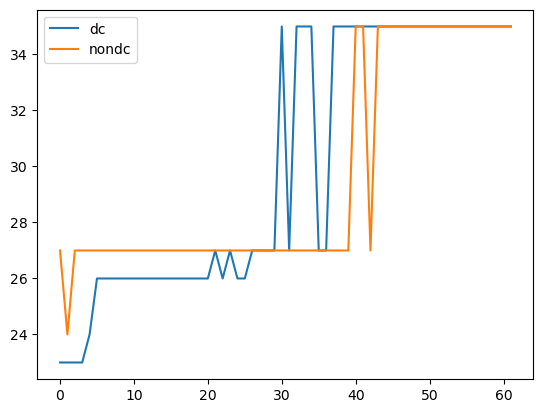

In [68]:
fig, ax = plt.subplots()
ax.plot(zdrift_dc['matched_plane_indices'], label='dc')
ax.plot(zdrift_nondc['matched_plane_indices'], label='nondc')
ax.legend()

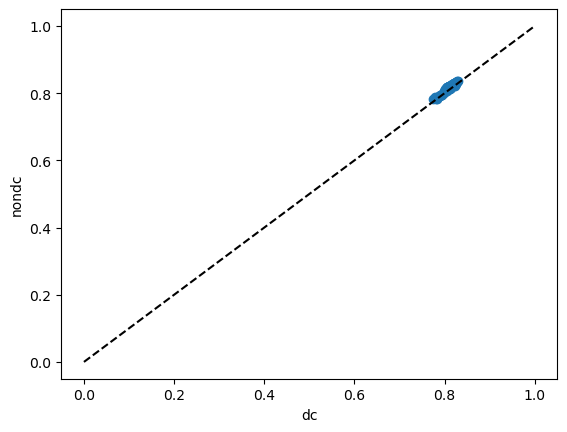

In [69]:
fig, ax = plt.subplots()
ax.scatter(np.max(zdrift_dc['corrcoef'], axis=1), np.max(zdrift_nondc['corrcoef'], axis=1))
ax.set_xlabel('dc')
ax.set_ylabel('nondc')
ax.plot([0, 1], [0, 1], color='k', linestyle='--')

Text(0.5, 1.0, 'Non de-crosstalked')

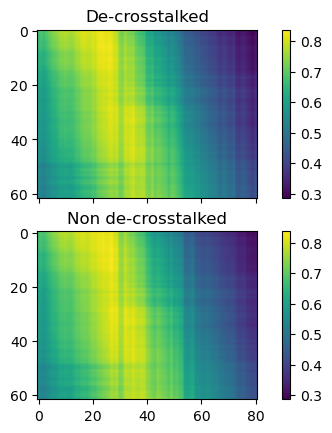

In [70]:
fig, ax = plt.subplots(2, 1, sharex=True)
vmax = np.max([zdrift_dc['corrcoef'], zdrift_nondc['corrcoef']])
vmin = np.min([zdrift_dc['corrcoef'], zdrift_nondc['corrcoef']])
im = ax[0].imshow(zdrift_dc['corrcoef'], vmax=vmax, vmin=vmin)
fig.colorbar(im, ax=ax[0])
ax[0].set_title('De-crosstalked')

im = ax[1].imshow(zdrift_nondc['corrcoef'], vmax=vmax, vmin=vmin)
fig.colorbar(im, ax=ax[1])
ax[1].set_title('Non de-crosstalked')


In [41]:
np.stack(zdrift_dc['segment_fov_registered']).shape

(62, 495, 488)

In [42]:
viewer = napari.Viewer()
viewer.add_image(np.stack(zdrift_dc['segment_fov_registered']), name='dc')
viewer.add_image(np.stack(zdrift_nondc['segment_fov_registered']), name='nondc')

<Image layer 'nondc' at 0x1a11616a070>

In [43]:
viewer = napari.Viewer()
viewer.add_image(zdrift_dc['zstack_crop'], name='dc')
viewer.add_image(zdrift_nondc['zstack_crop'], name='nondc')

<Image layer 'nondc' at 0x1a14bea8a00>

### DC vs non-DC
- Seems not much difference between the two
- Maybe due to Axon laser having lower rep rate
- there is a slight difference in number of frames
- Compare matched indices, max correlations
- Some results are bad
    - Figure out how many, and why

In [44]:
data_dir = Path(r'D:\zdrift_test\zdrift')
opids = [id for id in os.listdir(data_dir) if id.isnumeric() and (data_dir/id).is_dir() and (data_dir/id/f'{id}_zdrift_pconly_nondc.npy').exists()]
print(len(opids))

10


In [92]:
mpi_diff = []
max_cc_diff = []
error_opids = []
all_cc_dc = []
all_cc_nondc = []
for opid in opids:
    opid_dir = data_dir/opid
    try:
        zdrift_dc = np.load(opid_dir/f'{opid}_zdrift_pconly_dc.npy', allow_pickle=True).item()
        zdrift_nondc = np.load(opid_dir/f'{opid}_zdrift_pconly_nondc.npy', allow_pickle=True).item()
        mpi_dc = zdrift_dc['matched_plane_indices']
        mpi_nondc = zdrift_nondc['matched_plane_indices']
        num_frames = min(len(mpi_dc), len(mpi_nondc))
        mpi_diff.append(np.mean(np.abs(mpi_dc[:num_frames] - mpi_nondc[:num_frames])))

        max_cc_dc = np.max(zdrift_dc['corrcoef'], axis=1)
        max_cc_nondc = np.max(zdrift_nondc['corrcoef'], axis=1)

        all_cc_dc.append(max_cc_dc[:num_frames])
        all_cc_nondc.append(max_cc_nondc[:num_frames])

        max_cc_diff.append(np.mean(max_cc_dc[:num_frames] - max_cc_nondc[:num_frames]))
    except:
        error_opids.append(opid)
assert len(error_opids) == 0



Text(0, 0.5, 'count')

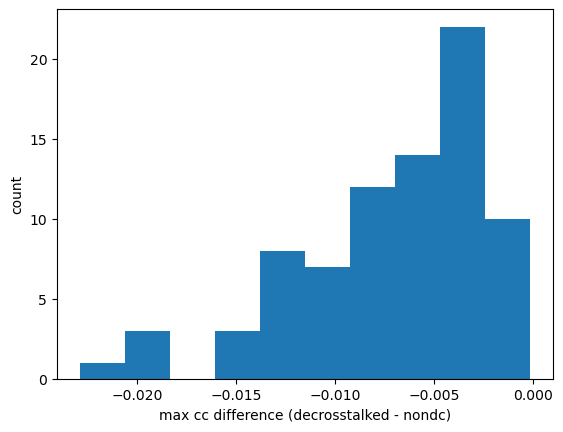

In [87]:
fig, ax = plt.subplots()
ax.hist(max_cc_diff)
ax.set_xlabel('max cc difference (decrosstalked - nondc)')
ax.set_ylabel('count')

Text(0.5, 1.0, 'CC difference: -0.01 /+- 0.01 (dc - nondc)')

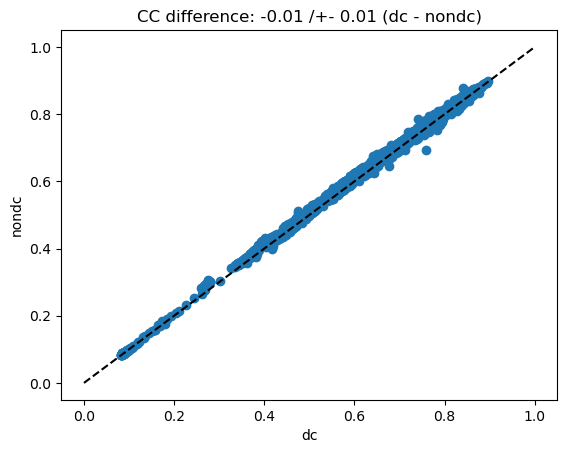

In [96]:
fig, ax = plt.subplots()
ax.scatter(np.concatenate(all_cc_dc), np.concatenate(all_cc_nondc))
ax.set_xlabel('dc')
ax.set_ylabel('nondc')
ax.plot([0, 1], [0, 1], color='k', linestyle='--')
diff_all_cc = np.concatenate(all_cc_dc) - np.concatenate(all_cc_nondc)
ax.set_title(f'CC difference: {np.mean(diff_all_cc):.2f} /+- {np.std(diff_all_cc):.2f} (dc - nondc)')

Text(0.5, 0, 'Mean difference in matched plane index')

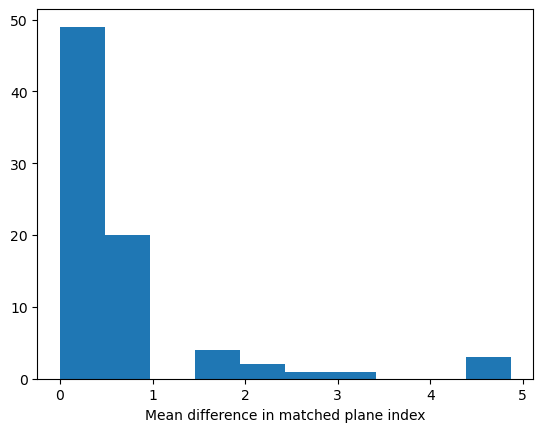

In [88]:
fig, ax = plt.subplots()
ax.hist(mpi_diff)
ax.set_xlabel('Mean difference in matched plane index')

Text(0, 0.5, 'Max CC (decrosstalked)')

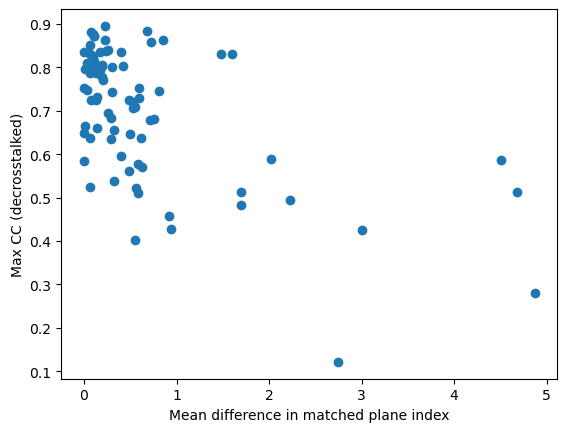

In [98]:
fig, ax = plt.subplots()
ax.scatter(mpi_diff, [max(c) for c in all_cc_dc])
ax.set_xlabel('Mean difference in matched plane index')
ax.set_ylabel('Max CC (decrosstalked)')

## Look at some examples of bad results
- low cc first
- then high difference in cc and dc

In [99]:
cc_per_opid = np.array([max(c) for c in all_cc_dc])
low_cc_inds = np.where(cc_per_opid < 0.6)[0]
low_cc_opids = [opids[i] for i in low_cc_inds]


Text(0.5, 1.0, '1301114437 (max cc: 0.51)')

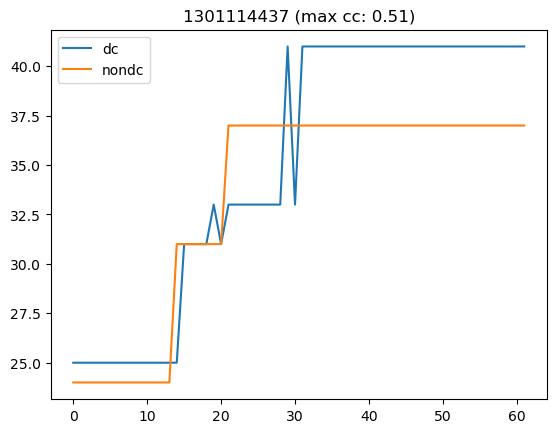

In [104]:
opid = low_cc_opids[4]
cc = cc_per_opid[low_cc_inds[5]]
opid_dir = data_dir/opid
zdrift_dc = np.load(opid_dir/f'{opid}_zdrift_pconly_dc.npy', allow_pickle=True).item()
zdrift_nondc = np.load(opid_dir/f'{opid}_zdrift_pconly_nondc.npy', allow_pickle=True).item()
fig, ax = plt.subplots()
ax.plot(zdrift_dc['matched_plane_indices'], label='dc')
ax.plot(zdrift_nondc['matched_plane_indices'], label='nondc')
ax.legend()
ax.set_title(f'{opid} (max cc: {cc:.2f})')

In [105]:
viewer = napari.Viewer()
viewer.add_image(zdrift_dc['zstack_crop'], name='dc')
viewer.add_image(zdrift_nondc['zstack_crop'], name='nondc')

<Image layer 'nondc' at 0x1a17c73f190>

In [102]:
viewer = napari.Viewer()
viewer.add_image(np.stack(zdrift_dc['segment_fov_registered']), name='dc')
viewer.add_image(np.stack(zdrift_nondc['segment_fov_registered']), name='nondc')


<Image layer 'nondc' at 0x1a1291c0eb0>

# Archive

# motion correction for z-stack

In [7]:
data_dir = Path(r'D:\zdrift_test\zdrift')
opids = [id for id in os.listdir(data_dir) if id.isnumeric() and (data_dir/id).is_dir()]


In [78]:
# one example
opid = opids[0]
opid_dir = data_dir/opid

emf_movie = np.load(opid_dir/'emf_movie.npy')
zstack = np.load(opid_dir/'ref_zstack.npy')
xy_range = np.load(opid_dir/'xy_range.npy', allow_pickle=True)

In [9]:
# check zstack reg quality
# - looks good
viewer = napari.Viewer()
viewer.add_image(emf_movie, name='emf_movie')
viewer.add_image(zstack, name='zstack')


<Image layer 'zstack' at 0x1d5e8b7ea60>

In [86]:
def suite2p_nonrigid_shift(frames, yoff, xoff, yoff1, xoff1, blocks):
    for frame, dy, dx in zip(frames, yoff, xoff):
        frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)
    frames = nonrigid.transform_data(frames, yblock=blocks[0], xblock=blocks[1], nblocks=blocks[2],
                                         ymax1=yoff1, xmax1=xoff1)
    return frames

In [84]:
# apply the mean of 1 min registration from motion correction to the zstack
frame_rate = 40
stack_order = 'after'

block_size = [128, 128]
Ly = 512
Lx = 512
blocks = nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=block_size)

num_frame_per_min = int(60 * frame_rate)
mc_table = pd.read_csv(opid_dir/f'{opid}_motion_transform.csv')
if stack_order == 'after':
    mc_table = mc_table.iloc[-num_frame_per_min:]
elif stack_order == 'before':
    mc_table = mc_table.iloc[:num_frame_per_min]
else:
    raise ValueError(f'Invalid stack_order: {stack_order}')

def _change_str_to_array(text):
    return np.array([float(x) for x in text.split('[')[1].split(']')[0].split(',')])
mc_table['nonrigid_x_array'] = mc_table.nonrigid_x.apply(lambda x: _change_str_to_array(x))
mc_table['nonrigid_y_array'] = mc_table.nonrigid_y.apply(lambda x: _change_str_to_array(x))

mean_x = int(np.round(mc_table.x.mean()))
mean_y = int(np.round(mc_table.y.mean()))
mean_x_nr = mc_table.nonrigid_x_array.mean().astype(np.float32)
mean_y_nr = mc_table.nonrigid_y_array.mean().astype(np.float32)

xoff = np.full(zstack.shape[0], mean_x)
yoff = np.full(zstack.shape[0], mean_y)
xoff1 = np.tile(mean_x_nr, (zstack.shape[0], 1))
yoff1 = np.tile(mean_y_nr, (zstack.shape[0], 1))

zstack = zstack.astype(np.float32)
mc_zstack = suite2p_nonrigid_shift(zstack, yoff, xoff, yoff1, xoff1, blocks)


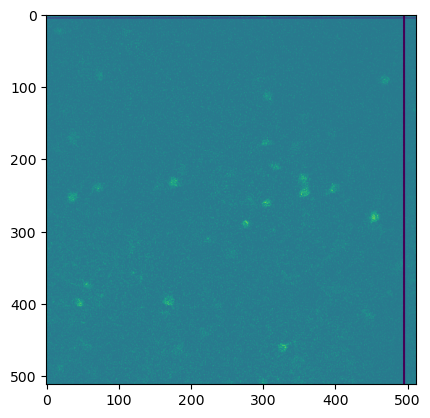

In [87]:
plt.imshow(zstack[0])

In [85]:
viewer.add_image(mc_zstack, name='mc_zstack')

<Image layer 'mc_zstack' at 0x1d583aa1e80>

In [81]:
type(yoff1[0,0])

numpy.float32

In [46]:
zstack.shape

(81, 512, 512)

In [66]:
type(zstack[0,0,0])

numpy.float64

In [39]:
mc_table

,framenumber,x,y,x_pre_clip,y_pre_clip,correlation,is_valid,nonrigid_x,nonrigid_y,nonrigid_corr,nonrigid_x_array,nonrigid_y_array
140613,140613,-73,102,-73,102,0.001905,True,"[ 3.2, 0.4,-1.1,-0.8, 0.2, 1.1,-5.5,-2.2,-3. ,...","[ 4.1,-6. , 5.2, 4.7, 0.5, 1.2, 5.6,-5.1, 7.3,...","[0.00509574,0.00232574,0.00541115,0.00151438,0...","[3.2, 0.4, -1.1, -0.8, 0.2, 1.1, -5.5, -2.2, -...","[4.1, -6.0, 5.2, 4.7, 0.5, 1.2, 5.6, -5.1, 7.3..."
140614,140614,34,-30,34,-30,0.001945,True,"[-1.2, 1.4,-3.4,-3.9,-3.9, 3.2, 1.8, 1.6, 0.5,...","[ 0.4 ,-6.8 ,-1.6 ,-0.9 ,-...","[0.00395074,0.00277247,0.00232016,0.00386571,0...","[-1.2, 1.4, -3.4, -3.9, -3.9, 3.2, 1.8, 1.6, 0...","[0.4, -6.8, -1.6, -0.9, -1.2, 2.3, 2.6, 2.5, 0..."
140615,140615,-8,-93,-8,-93,0.001684,True,"[ 1.5999999,-2.8 ,-2.1 ,-2.4 ,-...","[-7.3 ,-0.10000002,-2.4 ,-0.9 ...","[0.00248696,0.00186194,0.00276561,0.00160848,0...","[1.5999999, -2.8, -2.1, -2.4, -5.6, -8.0, 1.8,...","[-7.3, -0.10000002, -2.4, -0.9, 0.70000005, -4..."
140616,140616,-17,71,-17,71,0.001893,True,"[ 0.1,-0.7,-1.3, 1.5, 4.3, 1.9,-0.6,-0.7,-1.5,...","[ 2.5,-2. ,-2.2, 5.8,-5.1, 6.6,-2.1,-1.9,-1.7,...","[0.00276432,0.00204001,0.0013598 ,0.00208051,0...","[0.1, -0.7, -1.3, 1.5, 4.3, 1.9, -0.6, -0.7, -...","[2.5, -2.0, -2.2, 5.8, -5.1, 6.6, -2.1, -1.9, ..."
140617,140617,69,-12,69,-12,0.001808,True,"[ 0.7, 0.7,-0.9,-0.9, 4.8, 4.8, 1. , 0.8, 0.4,...","[-0.1,-0.2,-5.3,-5.6, 3.1, 3.1,-0.4,-0.4,-0.6,...","[0.00496831,0.00177747,0.0012761 ,0.00192842,0...","[0.7, 0.7, -0.9, -0.9, 4.8, 4.8, 1.0, 0.8, 0.4...","[-0.1, -0.2, -5.3, -5.6, 3.1, 3.1, -0.4, -0.4,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
143008,143008,16,90,16,90,0.001897,True,"[ 6.5, 6.9, 0.5,-1. ,-1.7,-1.8, 6.4, 0.3, 0.4,...","[-2.5,-2.1, 0.9, 1.5, 1.1, 0.7,-3.1, 0.4, 0.8,...","[0.00256154,0.00225173,0.001602 ,0.00174373,0...","[6.5, 6.9, 0.5, -1.0, -1.7, -1.8, 6.4, 0.3, 0....","[-2.5, -2.1, 0.9, 1.5, 1.1, 0.7, -3.1, 0.4, 0...."
143009,143009,-25,-19,-25,-19,0.001808,True,"[ 1.4 , 6.6 ,-1.9 ,-1.9 ,-...","[ 2.2 ,-5.8 , 0. ,-0.5 ...","[0.00245752,0.0035488 ,0.0024618 ,0.00251822,0...","[1.4, 6.6, -1.9, -1.9, -1.7, -1.8, -0.8, -1.8,...","[2.2, -5.8, 0.0, -0.5, -0.39999998, -0.4, -6.8..."
143010,143010,-58,66,-58,66,0.001803,True,"[ 0.3,-4.5,-4.1, 5.2, 5.3, 5.7,-0.1, 0.6,-2.7,...","[ 0.2, 3. , 3.2,-4. ,-4.4,-4.9,-0.1, 0.3, 2. ,...","[0.00357781,0.00363211,0.00143255,0.00185565,0...","[0.3, -4.5, -4.1, 5.2, 5.3, 5.7, -0.1, 0.6, -2...","[0.2, 3.0, 3.2, -4.0, -4.4, -4.9, -0.1, 0.3, 2..."
143011,143011,-5,-15,-5,-15,0.001914,True,"[ 1.3 , 1.4 ,-4.5 ,-4. ...","[ 1.2 , 0.9 ,-5.4 ,-6. ...","[0.00263901,0.00202946,0.0018011 ,0.00130654,0...","[1.3, 1.4, -4.5, -4.0, 6.0, 5.5, 1.3, -4.1, -3...","[1.2, 0.9, -5.4, -6.0, 3.3, 2.9, 1.2, -5.2, -5..."


In [34]:
def _change_str_to_array(text):
    return np.array([float(x) for x in text.split('[')[1].split(']')[0].split(',')])
mc_table['nonrigid_x_array'] = mc_table.nonrigid_x.apply(lambda x: _change_str_to_array(x))
mc_table['nonrigid_y_array'] = mc_table.nonrigid_y.apply(lambda x: _change_str_to_array(x))

In [36]:
mc_table.nonrigid_x_array.mean()

array([ 0.05816667, -0.05004167, -0.22845833, -0.00329167,  0.0125    ,
       -0.10683333, -0.21991667, -0.14408333,  0.01983333, -0.01925   ,
       -0.13291667,  0.01675   , -0.191125  , -0.168     ,  0.05079167,
        0.06145833, -0.22704167, -0.18695833, -0.46525   , -0.22741667,
        0.05770833, -0.07275   , -0.09770833, -0.20016667, -0.08670833,
       -0.39641667, -0.05379167,  0.45358333,  0.02983333,  0.03825   ,
       -0.012     ,  0.21620833,  0.09041667,  0.48879167,  0.39029167,
       -0.222375  ])

In [37]:
mc_table.nonrigid_y_array.mean()

array([-0.02470833, -0.12208333, -0.36391667, -0.43754167, -0.643     ,
       -0.24279167,  0.14195833, -0.08008333, -0.00358333, -0.06545833,
       -0.27908333, -0.17370833,  0.53670833,  0.320875  ,  0.17908333,
        0.3025    ,  0.19875   ,  0.07608333,  0.75533333,  0.58179167,
        0.23416667,  0.1415    ,  0.10875   ,  0.09720833,  0.14645833,
        0.05104167,  0.18604167,  0.197625  ,  0.44533333,  0.69916667,
       -0.55095833, -0.33716667, -0.0885    ,  0.20708333,  0.63141667,
        0.55320833])